In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from osc_toolkit import oscillation, delayed_oscillation
from models import *

In [11]:
params = np.array([115.0, 6.0, 1, 25, 0])
consts = np.array([0.11, 1.5])
init_cond = [0.1, 0]

In [12]:
model_with_const = oscillation(approx_model_with_const, params, consts,init_cond, calc_all_approx_model_FTC)

In [13]:
model_with_const.interactive_plot(t=3, ran=40)

interactive(children=(FloatSlider(value=115.0, description='alpha', max=155.0, min=75.0, step=0.05), FloatSlid…

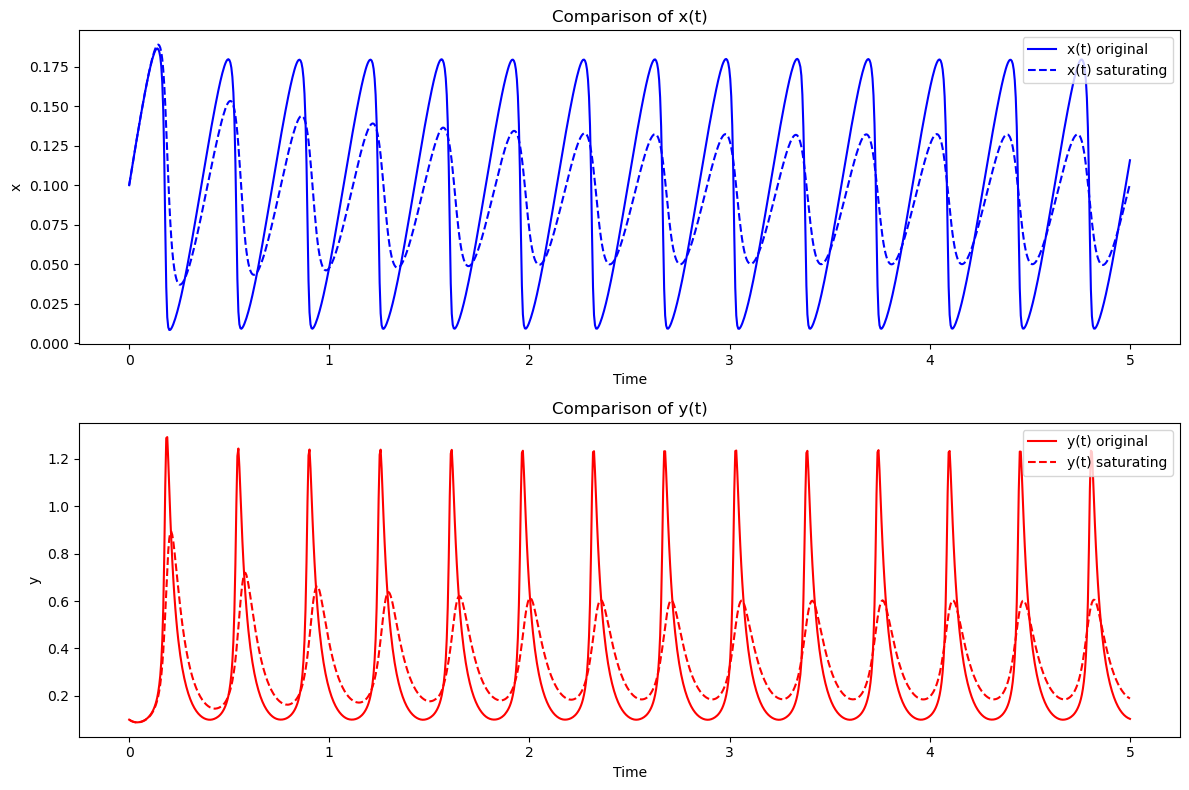

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Original model
def model_original(t, z, alpha, beta, theta, phi):
    x, y = z
    dxdt = 1 - alpha * x * y**2 - theta * x
    dydt = (alpha/0.11)*x*y**2 - beta*y**2 + (theta/0.11)*x - phi*y
    return [dxdt, dydt]

# Modified model with saturating nonlinearity
def model_saturating(t, z, alpha, beta, theta, phi, kappa):
    x, y = z
    # Saturated nonlinear term
    sat_term = x * y**2 / (1 + kappa * y**2)
    dxdt = 1 - alpha * sat_term - theta * x
    dydt = (alpha/0.11)*sat_term - beta*y**2 + (theta/0.11)*x - phi*y
    return [dxdt, dydt]

# Parameter values
alpha = 115.0
beta = 6.0
theta = 1.0
phi = 25.0
kappa = 1.5  # Adjust this parameter to tune the saturation effect

# Time span and evaluation points
t_span = (0, 5)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# Initial conditions
z0 = [0.1, 0.1]

# Solve the original system
sol_original = solve_ivp(model_original, t_span, z0, args=(alpha, beta, theta, phi), t_eval=t_eval)

# Solve the modified saturating system
sol_saturating = solve_ivp(model_saturating, t_span, z0, args=(alpha, beta, theta, phi, kappa), t_eval=t_eval)

# Plot the results
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(sol_original.t, sol_original.y[0], label='x(t) original', color='blue')
plt.plot(sol_saturating.t, sol_saturating.y[0], label='x(t) saturating', linestyle='--', color='blue')
plt.title('Comparison of x(t)')
plt.xlabel('Time')
plt.ylabel('x')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(sol_original.t, sol_original.y[1], label='y(t) original', color='red')
plt.plot(sol_saturating.t, sol_saturating.y[1], label='y(t) saturating', linestyle='--', color='red')
plt.title('Comparison of y(t)')
plt.xlabel('Time')
plt.ylabel('y')
plt.legend()

plt.tight_layout()
plt.show()


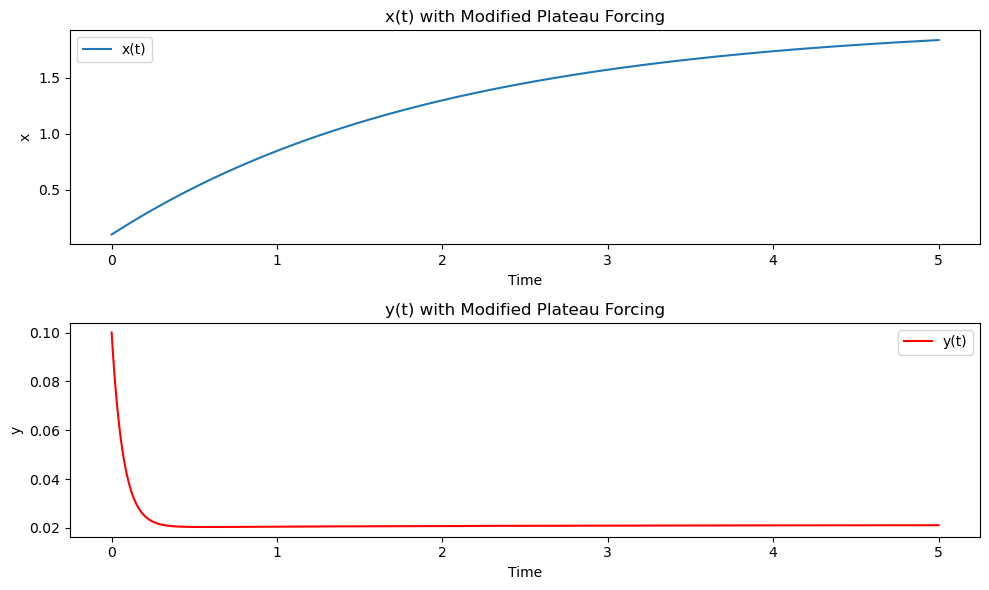

In [203]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def model_plateau_oscillation(t, z, alpha, beta, theta, phi, delta):
    x, y = z
    # Switching function: activates only when y exceeds y_c (set higher)
    k = 3.0       # steepness of the sigmoid
    y_c = 0.3      # higher threshold so that plateau forcing only occurs near the peak of y
    S = 1 / (1 + np.exp(-k * (y - y_c)))
    
    # When S ~ 0 (y is below threshold) the equations behave almost as originally.
    # When S ~ 1 (y is high) the nonlinear term is suppressed and a plateau forcing δ is added.
    dxdt = 1 - alpha * (1 - S) * x * y**2  - theta * x
    dydt = (alpha / 0.11) * (1 - S) * x * y**2 - beta * y**2 * + (theta / 0.11) * x - phi * y + delta * S
    return [dxdt, dydt]

# Parameter values (original parameters)
alpha = 10.0
beta = 10.0
theta = 0.5
phi = 15.0
delta = 1.0  # moderate forcing to keep y high during the plateau phase

# Time span and evaluation points
t_span = (0, 5)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# Initial conditions for x and y
z0 = [0.1, 0.1]

# Solve the system
sol = solve_ivp(model_plateau_oscillation, t_span, z0, args=(alpha, beta, theta, phi, delta), t_eval=t_eval)

# Plot the results
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(sol.t, sol.y[0], label='x(t)')
plt.xlabel('Time')
plt.ylabel('x')
plt.title('x(t) with Modified Plateau Forcing')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(sol.t, sol.y[1], label='y(t)', color='red')
plt.xlabel('Time')
plt.ylabel('y')
plt.title('y(t) with Modified Plateau Forcing')
plt.legend()

plt.tight_layout()
plt.show()


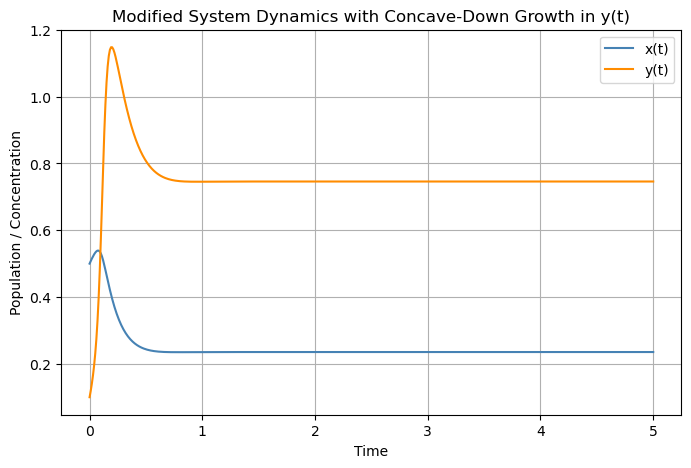

In [223]:
import numpy as np
from math import sqrt
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters (you can adjust these to see different oscillatory behaviors)
alpha = 15.0    # original interaction rate
beta  = 15.0    # self-limiting rate for y (quadratic term)
theta = 0.3    # decay rate for x
phi   = 1    # decay rate for y (linear term)
K     = 2    # saturation parameter for the growth-limiting function

# Growth-limiting function: strong at low y, weaker at high y
def growth_limit(y):
    """Saturating function g(y) = y^2 / (1 + K*y^2)."""
    return (y**2) / (1 + K * (y**2))

# ODE system with modified terms
def dydt(t, vars):
    x, y = vars  # unpack the state variables
    # Modified derivatives incorporating the saturating growth_limit(y)
    dxdt = 1 - alpha * x * growth_limit(y) - theta * x
    dydt = (alpha/0.11) * x * growth_limit(y)  -  beta * (y**2)  +  (theta/0.11) * x  -  phi * y
    return [dxdt, dydt]

# Initial conditions and time span for simulation
x0, y0 = 0.5, 0.1                      # initial values for x and y
t_start, t_end = 0, 5                 # simulate from t=0 to t=50 (time units)
t_eval = np.linspace(t_start, t_end, 500)  # time points at which to store the solution

# Solve the ODE system
solution = solve_ivp(dydt, [t_start, t_end], [x0, y0], t_eval=t_eval, rtol=1e-8, atol=1e-8)

# Extract the results
t = solution.t
x_t = solution.y[0]
y_t = solution.y[1]

# Plot the results
plt.figure(figsize=(8,5))
plt.plot(t, x_t, label='x(t)', color='steelblue')
plt.plot(t, y_t, label='y(t)', color='darkorange')
plt.xlabel('Time')
plt.ylabel('Population / Concentration')  # adjust label based on context (population, concentration, etc.)
plt.title('Modified System Dynamics with Concave-Down Growth in y(t)')
plt.legend()
plt.grid(True)
plt.show()
